# Quantile Regressions

This notebook illustrates quantile regressions.

You may also want to consider the [QuantileRegressions.jl](https://github.com/pkofod/QuantileRegressions.jl) package.

## Load Packages and Extra Functions

In [1]:
using LinearAlgebra, Printf, DelimitedFiles, Statistics

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))            #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

## Loading Data

In [3]:
xx  = readdlm("Data/FFdFactors.csv",',',skipstart=1)
xx  = xx[:,2]            #equity market excess returns

y = xx[2:end]            #dependent variable
x = xx[1:end-1]          #regressor in an AR(1)

T   = size(y,1)
println("Sample size: $T")

Sample size: 15355


## A Function for Quantile Regressions

The next cell defines a function `QuanRegrIRLSPs` which estimates a quantile regression. It uses a simple iterative (re-)weighted least squares (IRLS) approach. (It can be shown that a linear programming approach gives almost identical results for this data set.)

The subsequent cells calculate and show the results. The calculations take some time. 

In [4]:
"""
    QuanRegrIRLSPs(y,x,q=0.5)

Estimate a quantile regression for quantile `q`. The outputs are the point estimates 
and three different variance-covariance matrices of the estimates.

# Input
- `y::Vector`:     T vector, dependent variable
- `x::Matrix`:     TXK, regressors (including any constant)
- `q::Number`:     quantile to estimate at, 0<q<1
- `prec::Float64`: convergence criterion, 1e-8
- `epsu::Float64`: lower bound on 1/weight, 1e-6
- `maxiter::Int`:  maximum number of iterations, 1000

# Output
- `theta::Vector`: K vector, estimated coefficients
- `vcv::Matrix`:   KxK, traditional covariance matrix
- `vcv2::Matrix`:  KxK, Powell (1991) covariance matrix
- `vcv3::Matrix`:  KxK, Powell (1991) covariance matrix, uniform
"""
function QuantRegrIRLSPs(y,x::Matrix,q=0.5;prec=1e-8,epsu=1e-6,maxiter=1000)

  (T,K) = size(x)
  xw    = copy(x)

  (b_old,b,u,iter) = (zeros(K),fill(1e+6,K) .+ prec,zeros(T),0)

  while maximum(abs,b - b_old) > prec
    copyto!(b_old, b)
    b  .= (xw'*x)\(xw'*y)
    u  .= y - x*b
    #u  .= ifelse.(u.>0,1-q,q).*abs.(u)   #as in Python code, divide loss fn by q(1-q) to get it
    u  .= ifelse.(u.>0,1/q,1/(1-q)).*abs.(u)   #abs(u)/q if u>0, abs(u)/(1-q) if u<0
    u  .= max.(u,epsu)                         #not smaller than epsu
    xw .= x./u
    iter = iter + 1
    if iter > maxiter
      @warn("$iter > maxiter")
      b = NaN
      break
    end
  end

  res = y - x*b

  D   = x'x/T
  h   = 1.06*std(res)/T^0.2                        #Silverman (1986) recommendation
  fx  = exp.(-0.5*((res/h).^2))./(h*sqrt(2*pi))    #Green 7th ed, using N() kernel
  f0  = mean(fx)
  C   = f0*x'x/T
  C_1 = inv(C)
  vcv = q*(1-q)*C_1*D*C_1/T                         #variance-covariance matrix

  C    = (fx.*x)'x/T                                #Wooldrige 2dn ed, Powell 1991
  C_1  = inv(C)                                     #but with Gaussian kernel
  vcv2 = q*(1-q)*C_1*D*C_1/T                        #caputures (x,res) dependence

  fx  = (abs.(res) .<= h/2)/h                       #Wooldrige 2nd ed, Powell 1991
  C   = (fx.*x)'x/T                                 #uniform kernel
  C_1 = inv(C)
  vcv3 = q*(1-q)*C_1*D*C_1/T

  return b, vcv, vcv2, vcv3

end

QuantRegrIRLSPs

In [5]:
xGrid = quantile(x,0.01:0.01:0.99)                 #quantiles of the regressor, for plots
xGrid = [ones(size(xGrid)) xGrid]

qM = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]           #quantiles

cx = [ones(T) x]                                   #[constant regressors]

bM    = fill(NaN,length(qM),2)                     #to store regression coeffs
qPred = fill(NaN,length(qM),size(xGrid,1))         #to store predicted values
for i = 1:length(qM)
    #local b_q            #local/global is needed in script
    b_q        = QuantRegrIRLSPs(y,cx,qM[i])[1]
    bM[i,:]    = b_q
    qPred[i,:] = xGrid*b_q
end

printblue("quantile regression coefs:\n")
printmat(bM,colNames=["c","slope"],rowNames=string.(qM),cell00="quantile")

printred("\nThe function QuantRegrIRLSPs also outputs different variance-covariance matrices. Compare them.")

quantile regression coefs:

quantile         c     slope
0.01        -2.568     0.139
0.05        -1.433     0.158
0.25        -0.410     0.146
0.5          0.047     0.067
0.75         0.477     0.024
0.95         1.409    -0.028
0.99         2.582    -0.188


The function QuantRegrIRLSPs also outputs different variance-covariance matrices. Compare them.


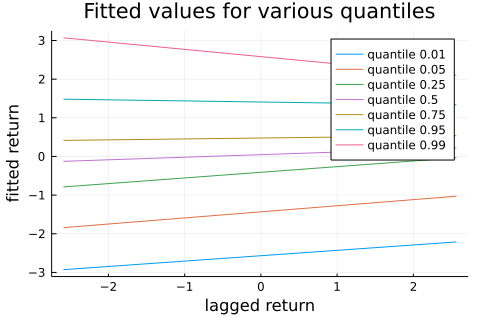

In [6]:
lab = permutedims(["quantile $(qM[i])" for i=1:length(qM)])

p1 = plot( xGrid[:,2],qPred',
           label = lab,
           xlabel = "lagged return",
           ylabel = "fitted return",
           title = "Fitted values for various quantiles" )
display(p1)